<a href="https://colab.research.google.com/github/YukaNakamura10/Analysis_of_mathmatical_equations_using_TrOCR_model/blob/main/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fine-tuning the TrOCR model

In [1]:
!pip install -q transformers==4.22.2
!pip install -q datasets jiwer

     |████████████████████████████████| 4.9 MB 7.9 MB/s 
     |████████████████████████████████| 182 kB 53.5 MB/s 
     |████████████████████████████████| 6.6 MB 60.5 MB/s 
     |████████████████████████████████| 451 kB 6.8 MB/s 
     |████████████████████████████████| 132 kB 93.2 MB/s 
     |████████████████████████████████| 212 kB 72.7 MB/s 
     |████████████████████████████████| 127 kB 73.3 MB/s 
     |████████████████████████████████| 1.4 MB 74.7 MB/s 
     |████████████████████████████████| 2.2 MB 58.0 MB/s 


In [5]:
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/equations.xlsx', header=None)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
# del df[2]
# # some file names end with jp instead of jpg, let's fix this
# df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)
df.head()

,file_name,text
0,equation1.jpg,1+1=2
1,equation2.jpg,y=x+1
2,equation3.jpg,x\times2=2x
3,equation4.jpg,3-2=1
4,equation5.jpg,y=x^2


# New Section

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New section

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir='/content/drive/MyDrive/image/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='/content/drive/MyDrive/image/',
                           df=test_df,
                           processor=processor)


Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 120
Number of validation examples: 30


In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


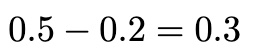

In [ ]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

0.5-0.2=0.3


In [ ]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

Downloading:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    output_dir="/content/drive/MyDrive/Project/",
    logging_steps=20,
    save_steps=1200,
    eval_steps=20,
    num_train_epochs=10,
    fp16=True
)

In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

<ipython-input-15-c81d87c6f9c2>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 120
  Num Epochs = 10
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 1200


Step,Training Loss,Validation Loss,Cer
20,7.690000,5.264897,1.000000
40,5.400000,5.352404,3.516393
60,4.882100,4.852080,0.965164
80,4.992300,4.676059,1.151639
100,4.851300,4.510344,1.165984
120,4.667300,4.649752,1.079918
140,4.161100,4.468920,1.307377
160,3.920400,4.144623,0.893443
180,3.733100,4.182664,0.889344
200,3.841400,3.943739,1.561475


***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 

TrainOutput(global_step=1200, training_loss=3.036970678965251, metrics={'train_runtime': 1942.5563, 'train_samples_per_second': 0.618, 'train_steps_per_second': 0.618, 'total_flos': 1.0618745407930368e+18, 'train_loss': 3.036970678965251, 'epoch': 10.0})

# Testing the saved model
Testing the model with a simple equation.

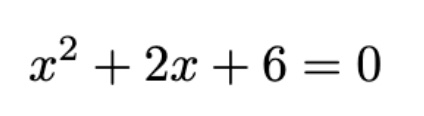

In [41]:
import requests
from PIL import Image

image = Image.open('/content/drive/MyDrive/image/equation11.jpg').convert("RGB")
image
    

In [35]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
# calling the processor is equivalent to calling the feature extractor


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 384, 384])


In [44]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


ac2t2ac +6-O.
